## Classifying Maternal Health Risk using Machine Learning Models

#### Import Statements

In [315]:
# Sci-Kit Learn Library

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [316]:
# Pandas Library
import pandas as pd

In [317]:
# NumPy Library
import numpy as np

In [318]:
# Matplotlib Library
import matplotlib.pyplot as plt

#### Importing the Dataset

In [320]:
df = pd.read_csv('MaternalRisk.csv')

In [321]:
risk_mapping = {
    'high risk': 2,
    'mid risk': 1,
    'low risk': 0
}

df['RiskLevel'] = df['RiskLevel'].map(risk_mapping)

In [322]:
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

In [323]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Finding Optimal Hyperparameters

In [325]:
# Logistic Regression
lr = LogisticRegression(random_state = 10)

param_grid = {'C': np.logspace(-4,4,10)}

grid_search = GridSearchCV(lr, param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_search.fit(X_scaled, y)

best_c = grid_search.best_params_['C']

print(f"Best C: {best_c:.6f}")

Best C: 0.005995


In [326]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=10)

param_grid = {'max_depth': list(range(1,5))}

grid_search = GridSearchCV(dt, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y)

best_max_depth = grid_search.best_params_['max_depth']

print(f"Best Max Depth: {best_max_depth}")

Best Max Depth: 4


In [327]:
# Random Forest
rf = RandomForestClassifier(random_state = 10)

param_grid = {'max_features': list(range(1, 7))}

grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', cv=10, n_jobs=-1)
grid_search.fit(X_scaled, y)

best_max_features = grid_search.best_params_['max_features']

print(f"Best # of Max Features: {best_max_features}")

Best # of Max Features: 1


#### Models with Optimized Hyperparameters

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=10)

In [330]:
# Logistic Regression
LR = LogisticRegression(C=best_c)
LR.fit(X_train, y_train)

LogisticRegression(C=0.005994842503189409)

In [331]:
# Decision Tree
DT = DecisionTreeClassifier(max_depth=best_max_depth)
DT.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

In [332]:
# Random Forest
RF = RandomForestClassifier(max_features=best_max_features)
RF.fit(X_train,y_train)

RandomForestClassifier(max_features=1)

#### Model Comparison

In [334]:
# Logistic Regression
LR = LogisticRegression(C=best_c)
LR.fit(X_train, y_train)
y_pred_LR = LR.predict(X_test)
LR_accuracy = accuracy_score(y_test, y_pred_LR)
print(f"Logistic Regression Accuracy: {LR_accuracy}")

Logistic Regression Accuracy: 0.5763546798029556


In [335]:
# Decision Tree
DT = DecisionTreeClassifier(max_depth=best_max_depth, random_state=10)
DT.fit(X_train,y_train)
y_pred_DT = DT.predict(X_test)
DT_accuracy = accuracy_score(y_test, y_pred_DT)
print(f"Decision Tree Accuracy: {DT_accuracy}")

Decision Tree Accuracy: 0.645320197044335


In [336]:
# Random Forest
RF = RandomForestClassifier(random_state = 10,max_features=best_max_features)
RF.fit(X_train,y_train)
y_pred_RF = RF.predict(X_test)
RF_accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Random Forest Accuracy: {RF_accuracy}")

Random Forest Accuracy: 0.8226600985221675


#### Confusion Matrices

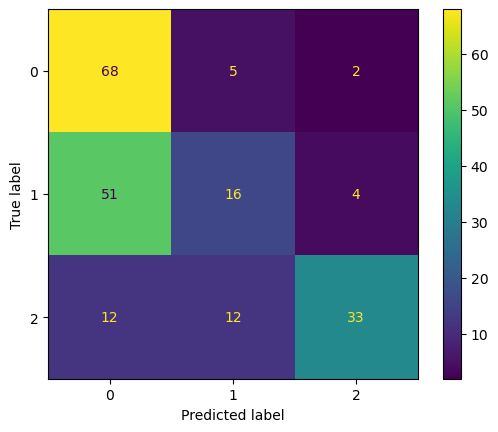

In [338]:
# Logistic Regression
LR_conf_matrix = confusion_matrix(y_test, y_pred_LR)

display = ConfusionMatrixDisplay(confusion_matrix=LR_conf_matrix)
display.plot()
plt.show()

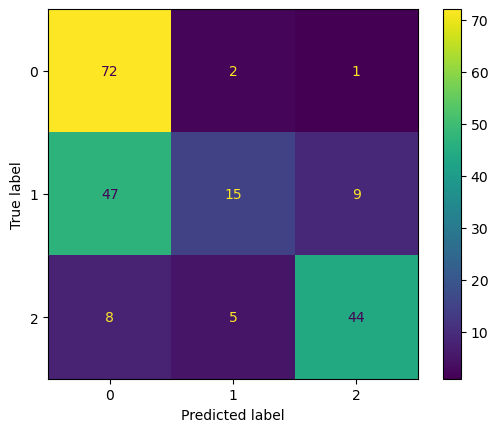

In [371]:
# Decision Tree
DT_conf_matrix = confusion_matrix(y_test, y_pred_DT)

display = ConfusionMatrixDisplay(confusion_matrix=DT_conf_matrix)
display.plot()
plt.show()

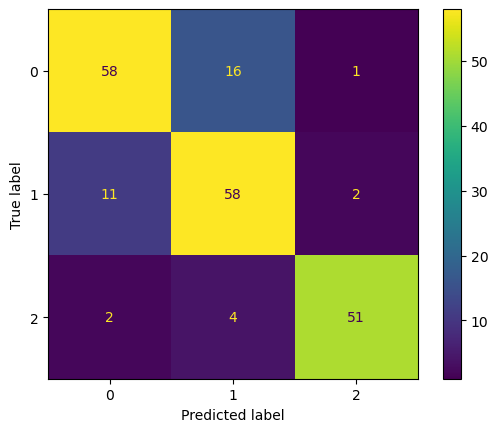

In [340]:
RF_conf_matrix = confusion_matrix(y_test, y_pred_RF)

display = ConfusionMatrixDisplay(confusion_matrix=RF_conf_matrix)
display.plot()
plt.show()

#### Feature Importance

In [342]:
# Logistic Regression
# magnitude of coefficients

In [343]:
# Decision Tree
# visualize tree

In [344]:
# Random Forest
# use pg 361 from ISLP